In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
#Import libraries and setup
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [4]:
#Load preprocessed data
base_path = '/content/drive/MyDrive/MLProjects/pneumonia-detection/data/pneumonia_split'
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train'), target_size=img_size, batch_size=batch_size, class_mode='binary'
)
val_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'val'), target_size=img_size, batch_size=batch_size, class_mode='binary'
)
test_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'test'), target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False
)

Found 2003 images belonging to 2 classes.
Found 429 images belonging to 2 classes.
Found 430 images belonging to 2 classes.


In [5]:
#Build VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False #Freeze for first stage

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(1e-4), loss = 'binary_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [10]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=2, restore_best_weights=True)

In [12]:
#Training the head only
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1140s 18s/step - accuracy: 0.5610 - loss: 1.0240 - val_accuracy: 0.6434 - val_loss: 0.6344
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6735 - loss: 0.5997 - val_accuracy: 0.6737 - val_loss: 0.6208
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7110 - loss: 0.5852 - val_accuracy: 0.6853 - val_loss: 0.6084
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7153 - loss: 0.5567 - val_accuracy: 0.6946 - val_loss: 0.6171
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7132 - loss: 0.5576 - val_accuracy: 0.7133 - val_loss: 0.5930


In [13]:
#Fine-tune VGG16
base_model.trainable = True #Unfreeze the base
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7461 - loss: 0.5214 - val_accuracy: 0.6830 - val_loss: 0.6274
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7509 - loss: 0.5379 - val_accuracy: 0.6900 - val_loss: 0.5920
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7589 - loss: 0.5168 - val_accuracy: 0.6853 - val_loss: 0.6042
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7718 - loss: 0.4949 - val_accuracy: 0.6923 - val_loss: 0.6297


In [14]:
#Evaluate on test set
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 286s 22s/step - accuracy: 0.6931 - loss: 0.6111
Test Accuracy: 0.7372, Loss: 0.5646


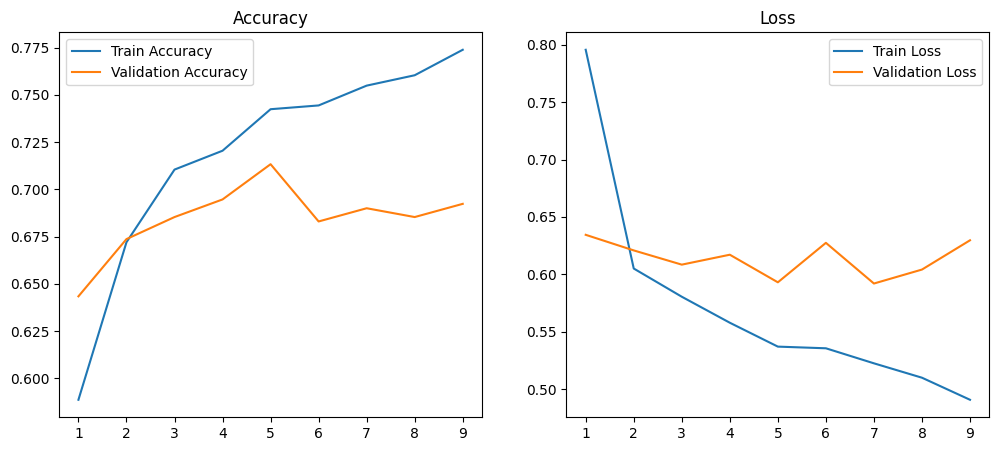

In [23]:
#Plotted both training stages(frozen base and fine-tuned) together
def plot_combined_histories(histories):
    acc = []
    val_acc = []
    loss = []
    val_loss = []

    for h in histories:
        acc.extend(h.history['accuracy'])
        val_acc.extend(h.history['val_accuracy'])
        loss.extend(h.history['loss'])
        val_loss.extend(h.history['val_loss'])

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_combined_histories([history1, history2])

In [26]:
model.save('vgg16_finetuned_model.h5')

Final VGG16 Results (Fine-Tuned):

* Validation Accuracy: 69.2%
* Test Accuracy: 73.7%
* Test Loss: 0.5646
* Two-stage training with frozen + unfrozen base layers
* Dropout (0.3) and EarlyStopping used to reduce overfitting
* Best performance among all models tested



This table compares all models tested for pneumonia detection:

| Model         | Val Acc | Test Acc | Notes                   |
|---------------|---------|----------|-------------------------|
| ResNet50      | ~51%    | ~19%     | Overfit badly           |
| DenseNet121   | ~65%    | ~56%     | Acceptable performance  |
| EfficientNetB0| ~52%    | ~20%     | Did not learn well      |
| VGG16         |   69%   |  73.7%   | Best model overall      |

ResNet50, DenseNet121, and EfficientNetB0 is trained in another notebook.